# Import Libraries

In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv, summary
import torch.nn.functional as F
import torch


# Create Directional Graph

Create directional graph as H

In [2]:
H = nx.DiGraph()

Define Nodes and Edges in H graph

In [3]:
#adding nodes
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),

  (1, {"color": "yellow", "size": 400}),

  (2, {"color": "orange", "size": 150}),

  (3, {"color": "red", "size": 600})
])

#adding edges
H.add_edges_from([
  (0, 1),

  (1, 2),

  (1, 0),

  (1, 3),

  (2, 3),

  (3,0)
])

Get graph node attributes

In [4]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

print(f"{colors = }")
print(f"{sizes = }")

colors = ['blue', 'yellow', 'orange', 'red']
sizes = [250, 400, 150, 600]


Plot graph H

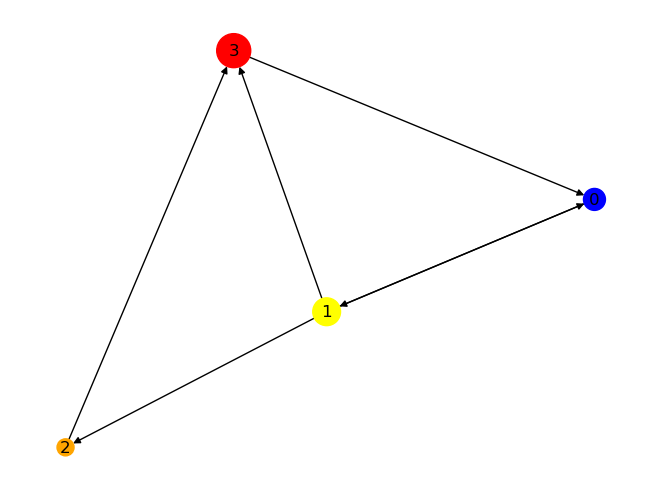

In [5]:
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

Convert directional to an undirectional graph

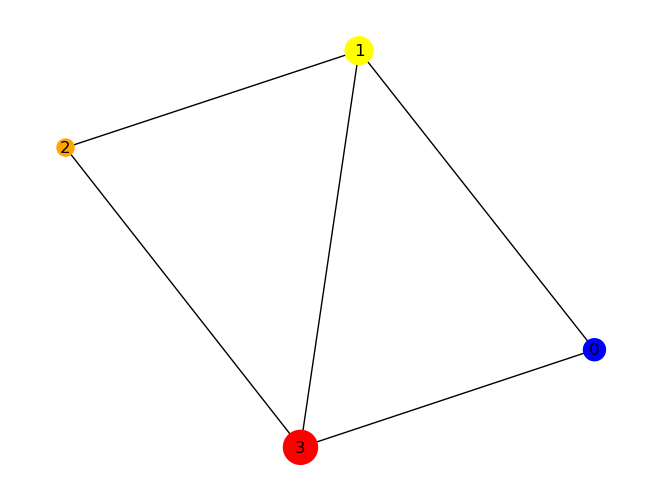

In [6]:
G = H.to_undirected()
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

# Building GCN Model

#### Get Cora Dataset
---
Nodes represent documents and edges represent citation links. Training, validation and test splits are given by binary masks.

In [7]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Print dataset detail

In [8]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print('======================')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [27]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, 54)
        self.conv2 = GCNConv(54, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

Show summary of model

In [28]:
model = GCN(hidden_channels=26)
print(summary(model, data.x, data.edge_index))

+------------------+--------------------------+----------------+----------+
| Layer            | Input Shape              | Output Shape   | #Param   |
|------------------+--------------------------+----------------+----------|
| GCN              | [2708, 1433], [2, 10556] | [2708, 7]      | 79,055   |
| ├─(conv1)GCNConv | [2708, 1433], [2, 10556] | [2708, 54]     | 77,436   |
| ├─(conv2)GCNConv | [2708, 54], [2, 10556]   | [2708, 26]     | 1,430    |
| ├─(conv3)GCNConv | [2708, 26], [2, 10556]   | [2708, 7]      | 189      |
+------------------+--------------------------+----------------+----------+


Define visualization function

In [29]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

Visualize model data before teraining

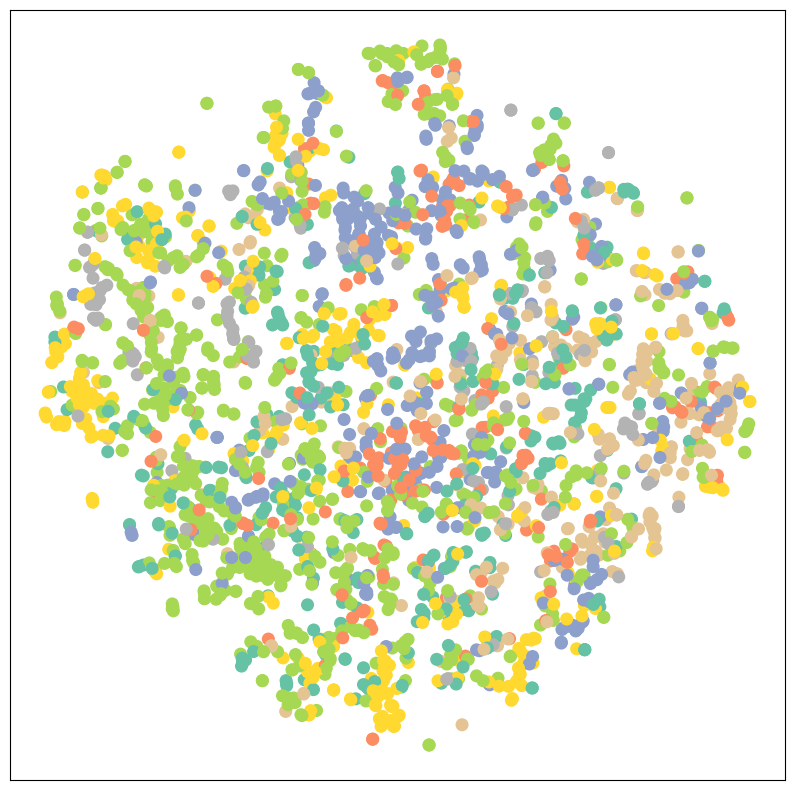

In [16]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# Train GCN model

Define train function 

In [17]:
def train(model, optimizer, criterion):
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return model, optimizer, criterion, loss

Define evaluation function

In [18]:
def test(model, mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      return test_acc

initial and Train GCN Model

In [30]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
    model, optimizer, criterion, loss = train(model, optimizer, criterion)
    val_acc = test(model, data.val_mask)
    test_acc = test(model, data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation Accuracy: {val_acc}, Test Accuracy: {test_acc}')

Epoch: 001, Loss: 1.9461, Validation Accuracy: 0.162, Test Accuracy: 0.15
Epoch: 002, Loss: 1.9425, Validation Accuracy: 0.178, Test Accuracy: 0.189
Epoch: 003, Loss: 1.9368, Validation Accuracy: 0.158, Test Accuracy: 0.179
Epoch: 004, Loss: 1.9286, Validation Accuracy: 0.186, Test Accuracy: 0.208
Epoch: 005, Loss: 1.9206, Validation Accuracy: 0.31, Test Accuracy: 0.316
Epoch: 006, Loss: 1.9083, Validation Accuracy: 0.458, Test Accuracy: 0.452
Epoch: 007, Loss: 1.8965, Validation Accuracy: 0.536, Test Accuracy: 0.514
Epoch: 008, Loss: 1.8796, Validation Accuracy: 0.548, Test Accuracy: 0.54
Epoch: 009, Loss: 1.8599, Validation Accuracy: 0.564, Test Accuracy: 0.551
Epoch: 010, Loss: 1.8382, Validation Accuracy: 0.566, Test Accuracy: 0.562
Epoch: 011, Loss: 1.8180, Validation Accuracy: 0.552, Test Accuracy: 0.56
Epoch: 012, Loss: 1.7906, Validation Accuracy: 0.554, Test Accuracy: 0.558
Epoch: 013, Loss: 1.7615, Validation Accuracy: 0.562, Test Accuracy: 0.561
Epoch: 014, Loss: 1.7209, Val

# Evaluate GCN model

Evaluate model with test data

In [31]:
test_acc = test(model, data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7870


Visualize model after training

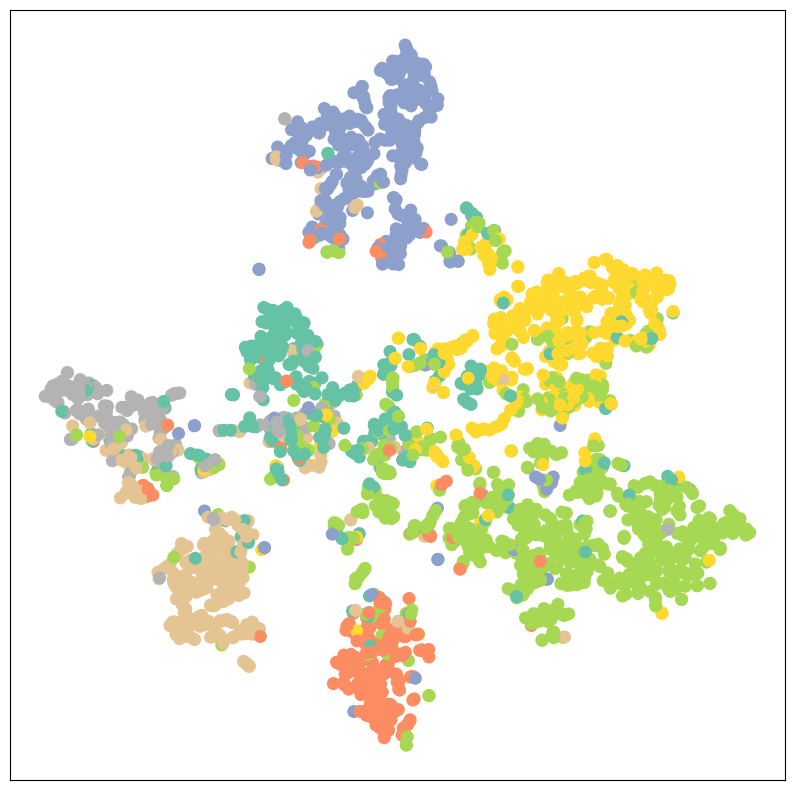

In [32]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [33]:
out[0]

tensor([-1.3867,  2.2025, -2.7308,  7.0631,  1.6571, -3.9594, -1.7617],
       grad_fn=<SelectBackward0>)